# 37: Transpose Convolution

## 🎯 Objective
Standard convolutions often shrink images (downsampling). But what if we need to make an image *larger*, like in Super-Resolution, GANs, or Semantic Segmentation? In this notebook, we explore the **Transpose Convolution** (`nn.ConvTranspose2d`), a layer that learns how to upsample data. We will examine its parameters, visualize its kernels, and observe how it expands the spatial dimensions of an input image compared to a standard convolution.

## 📚 Key Concepts
* **Upsampling:** The process of increasing the spatial resolution (height and width) of an image or feature map.
* **Transpose Convolution:** A learnable upsampling layer. It is mathematically the "transpose" of the convolution operation (sometimes colloquially called "Deconvolution", though this is technically a different mathematical operation).
* **Dimensionality Expansion:** Unlike standard convolution which typically reduces dimensions (e.g., 64x64 $\to$ 60x60), transpose convolution expands them (e.g., 64x64 $\to$ 68x68).

## 1. Import Libraries

We start by importing PyTorch for the deep learning layers and Matplotlib for visualizing the kernels and images.

In [1]:
# import libraries
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

## 2. Creating a Transpose Convolution Instance

Here we create an instance of `nn.ConvTranspose2d`. 

### Parameters
The parameters look identical to `nn.Conv2d` (channels, kernel size, stride), but the operation performed is the inverse in terms of spatial dimensions.
* **inChans (3):** RGB input.
* **outChans (15):** We want 15 output feature maps.
* **krnSize (5):** A 5x5 filter.

### Weights Shape
Note that for `ConvTranspose2d`, the weight tensor shape is **`[in_channels, out_channels, height, width]`**, which is slightly different from the standard convolution where input and output channels are swapped in the definition.

In [5]:
# create a ConvTranspose2d class instance with parameters

# parameters
inChans  = 3 # RGB
outChans = 15
krnSize  = 5 # should be an odd number
stride   = 1
padding  = 0

# create the instance
c = nn.ConvTranspose2d(inChans,outChans,krnSize,stride,padding)

# let's have a look at it
print(c)
print(' ')

# check out its weight tensor; what are the dimensions?
print( 'Size of weights: ' + str(c.weight.shape) )
print( 'Size of bias: ' + str(c.bias.shape) )

ConvTranspose2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
 
Size of weights: torch.Size([3, 15, 5, 5])
Size of bias: torch.Size([15])


## 3. Visualizing Transpose Kernels

Just like with standard convolution, we can visualize the weights. These filters are what the model uses to "paint" pixels onto the larger output grid. Since the model is untrained, they appear as random noise.

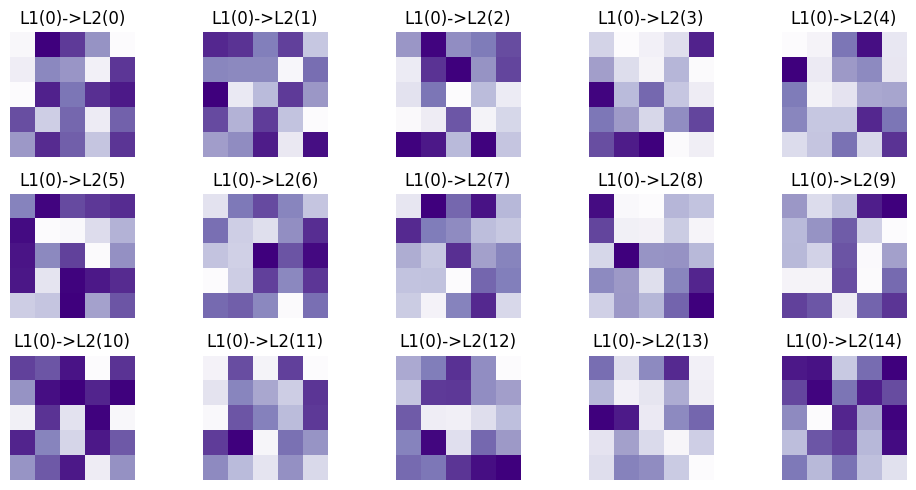

In [6]:
# What do these kernels look like?

fig,axs = plt.subplots(3,5,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):
  ax.imshow(torch.squeeze(c.weight[0,i,:,:]).detach(),cmap='Purples')
  ax.set_title('L1(0)->L2(%s)'%i)
  ax.axis('off')

plt.tight_layout()
plt.show()

## 4. Data Preparation

We create a random tensor of shape `(1, 3, 64, 64)` representing a batch of 1 RGB image, 64x64 pixels.

torch.Size([1, 3, 64, 64])
(64, 64, 3, 1)


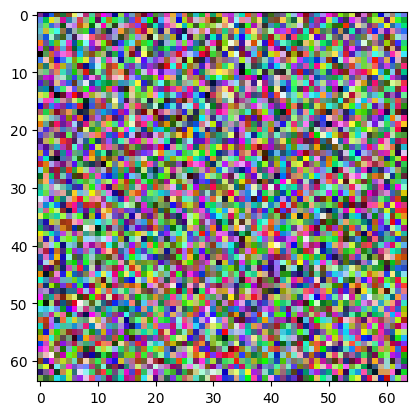

In [7]:
# size of the image (N, RGB, width, height)
imsize = (1,3,64,64)

img = torch.rand(imsize)

# pytorch wants channels first, but matplotlib wants channels last.
# therefore, tensors must be permuted to visualize
img2view = img.permute(2,3,1,0).numpy()
print(img.shape)
print(img2view.shape)

plt.imshow(np.squeeze(img2view));

## 5. The Forward Pass: Dimension Expansion

Now we pass the image through the Transpose Convolution layer.

### Observing the Output Size
Notice the change in dimensions. 
* **Input:** 64x64
* **Standard Convolution (previous notebook):** Shrank to 60x60.
* **Transpose Convolution (this notebook):** Expands to **68x68**.

The formula roughly follows: $\text{Output} = (\text{Input} - 1) \times \text{Stride} + \text{Kernel} - 2 \times \text{Padding}$. 
With Stride=1 and Kernel=5, it effectively adds padding rather than removing it.

In [8]:
# convolve the image with the filter bank (set of 'outChans' kernels)
convRes = c(img)

print(img.shape)
print(convRes.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 15, 68, 68])


## 6. Visualizing the Result

We visualize the 15 output feature maps. In a real application (like a Generator in a GAN), these feature maps would eventually be combined to form a high-resolution output image.

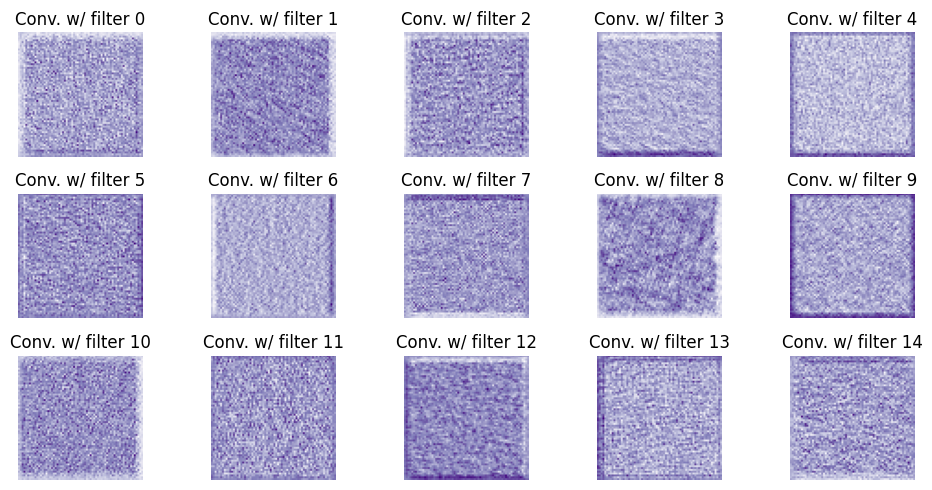

In [9]:
# What do the convolved images look like? (Hint: think of the bathtub picture.)

fig,axs = plt.subplots(3,5,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):

  # extract this "layer" of the convolution result
  I = torch.squeeze(convRes[0,i,:,:]).detach()

  # and visualize it
  ax.imshow(I,cmap='Purples')
  ax.set_title('Conv. w/ filter %s'%i)
  ax.axis('off')

plt.tight_layout()
plt.show()